In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology
from sklearn.cluster import DBSCAN, HDBSCAN
import time
import cv2

In [2]:
#timing wrapper to monitor function execution times
def timing(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"[INFO] '{func.__name__}' execution time: {end - start:.4f} s")
        return result
    return wrapper

Load files to process:

In [3]:
def list_files_recursive(path, extension):
    """
    lists files with given extension at path location
    """
    extension = extension.lower()
    return [str(p) for p in Path(path).rglob(f"*{extension}")]

In [4]:
files = list_files_recursive('/tf/ZEISS/data/', 'png')
test_imgs = []
for f in files:
    im = io.imread(f, as_gray=True) 
    test_imgs.append(im)

Cirle detection functions:

In [5]:
#circle class for storing circle coordinates and scores
class Circle:
    def __init__(self, x, y, radius, score=0.0):
        self.x = int(x)
        self.y = int(y)
        self.radius = int(radius)
        self.score = score

#edge map preprocessing function to filter out noise 
#edge map histograms are bimodal so Otsu will cut off low intensity noise from the edge detector
@timing
def preprocess_image(edge_map):
    """    
    :param edge_map: processed edge map
    :return: skeleton and binary images 
    """
    edge_map[[0, -1], :] = 0  # delete margin pixels
    edge_map[:, [0, -1]] = 0  

    edge_map_blur = filters.gaussian(edge_map, sigma=1)  # sigma ~ 1–2

    # Otsu
    thresh = filters.threshold_otsu(edge_map_blur)
    binary = edge_map_blur > thresh

    #morfological edge refining
    binary = morphology.erosion(binary, morphology.square(3))
    binary = morphology.dilation(binary, morphology.square(9))

    #compute image skeleton
    skeleton = morphology.skeletonize(binary)

    #thicken skeleton for score calculation
    binary = morphology.dilation(skeleton, morphology.square(3))

    #return both images
    return 255*binary.astype(np.uint8), 255*skeleton.astype(np.uint8)

#Hough gradient based transform circle detection
#Due to computional cost of the Multiscale Hough TransformO(N_points*N_radii) 
#the best choice would be Hough gradient based trnasform, however, due to its nature it processes gray scale images 
#to calculate gradients - here, I have edge map probabilities
#the first step of Canny - image blur - allows gradient computation that actually works
@timing
def detect_circles(img, param2, min_radius, max_radius):
    """
    :param img: analyzed image
    :param min_radius: min radius of sought circles
    :param max_radius: max radius of sought circles
    :return: 
    """

    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        dp=2,             #acumultor decimation 4x less points
        minDist=1,  #to allow concentric circle detection
        param1=10,  # Canny threshold: not significant because input images are binary/black and white
        param2=param2, #150, # accumulator threshold for hit counting
        minRadius=min_radius,
        maxRadius=max_radius
    )
    return circles

#compute edge score for a single circle
def edge_score(x, y, r, dist_map, tolerance=2.0, num_points=72):
    """
    :param x: center coordinate x
    :param y: center coordinate y
    :param r: circle radius r
    :param dist_map: distance map for the analyzed image: distance from the nearest image point (255 value)
    :param tolerance: distance tolerance margin to count hits
    :param num_points: number of angle space points to calculate circle points
    :return: calculated circle score
    """
    angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)

    xs = (x + r*np.cos(angles)).astype(int)
    ys = (y + r*np.sin(angles)).astype(int)

    xs = np.clip(xs, 0, dist_map.shape[1]-1)
    ys = np.clip(ys, 0, dist_map.shape[0]-1)

    hits = dist_map[ys, xs] < tolerance
    return np.sum(hits) / num_points

#calculate scores for circle list
#unfortunatelly cv2.HoughCircles does not provide the accumulator
#have to compute scores on my own to filter detections
@timing
def calc_scores(circles, dist_map, thr = 0.4):
    """
    :param circles: list of circles returned by detect_circles()
    :param dist_map: distance map for the analyzed image
    :param thr: 'good circle' threshold
    :return: list of Circle class objects
    """

    # thr = 0.4#0.5
    detected = []
    if circles is not None:
        detected = [
            Circle(x, y, r, score)
            for x, y, r in circles[0]
            if (score := edge_score(x, y, r, dist_map, tolerance=1.5, num_points=75)) > thr
        ]

    return detected

#perform DBScan clustering of detections and NMS suppresion in each cluster
#eps -> determined empirically via the 'elbow rule' of the nearest 2 neighbours dsitances between samples
#I have a small 'problem' with the feature vector: mixing radii with center coordinates
#is like comparing apples to oranges, but the normalization helped

@timing
def Dbscan_NMS(circles, shape, eps=0.0049, min_samples=1):
    """
    :param circles: list of Circle class objects
    :param eps: epsilon for DBScan
    :param min_samples: Cluster min sample size
    :return: list of Circle class objects that have the best circle score in each cluster
    """

    if len(circles) > 0:

        #feature vector: center coordinates plus radius
        data = np.array([[c.x, c.y, c.radius] for c in circles], dtype=float)

        data_scaled = data / [shape[0], shape[1], max(shape[0], shape[1])]

        db = DBSCAN(eps=eps, min_samples=min_samples)
        # db = HDBSCAN(min_cluster_size=2, min_samples=1)
        db.fit(data_scaled)
        clusters = [circles[np.where(db.labels_ == l)[0][0]] for l in np.unique(db.labels_) if l != -1]

    return clusters

@timing
def scale_image(img, scale):
    """
    Scales the content of the image, keeps image size

    :param img: input image to scale
    :param scale: scale < 1 - shrink image; scale > 1 expand image
    :return: scaled image
    """

    h, w = img.shape[:2]

    new_w = int(w * scale)
    new_h = int(h * scale)

    # img resize
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # empty canvas
    canvas = np.zeros_like(img)

    # resized position in canvas
    x = (w - new_w) // 2
    y = (h - new_h) // 2

    canvas[y:y+new_h, x:x+new_w] = resized
    return canvas

def plot_circles(circles, image, title):
    """
    :param circles: list of Circle class objects
    :param image: background image for circle presentation
    :param title: image title
    :return: resulting image background+circles
    """

    output = []
    if len(circles) > 0:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        for c in circles:
            cv2.circle(output, (c.x, c.y), c.radius, (255, 0, 0), 2)
            cv2.circle(output, (c.x, c.y), 2, (0, 255, 0), 3)

        plt.figure()
        plt.imshow(output)
        plt.title(title)

    return output

Edge maps processing:


File name: 
10.png

[INFO] 'preprocess_image' execution time: 0.2843 s
[INFO] 'detect_circles' execution time: 0.0548 s
[INFO] 'calc_scores' execution time: 0.0098 s
[INFO] 'Dbscan_NMS' execution time: 0.0237 s

Final results:
0: x, y, r: (1635, 1613, 112), score: 0.667


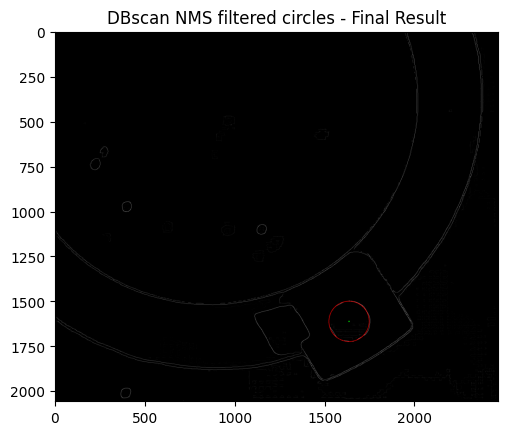

In [6]:
i = 0
img = test_imgs[i]

print('\nFile name: ')
print(files[i].split('/')[-1])
print()

binary, skeleton = preprocess_image(img)

circles = calc_scores(detect_circles(skeleton, param2=60, min_radius=50, max_radius=200), 
                      cv2.distanceTransform(255-binary, cv2.DIST_L2, 3), thr=0.4)
circles = sorted(circles, key=lambda c: c.score, reverse=True)

if len(circles) > 0:

    c_NMS = Dbscan_NMS(circles, img.shape, eps=0.0049, min_samples=1)
    plot_circles(c_NMS, img, "DBscan NMS filtered circles - Final Result")
    # plot_circles(circles, img, "all detected circles")

    print('\nFinal results:')
    for i, circle in enumerate(c_NMS):
            print(f'{i}: x, y, r: ({circle.x}, {circle.y}, {circle.radius}), score: {circle.score:.3f}')
else:
    print('\nNo circles detected')
    plt.imshow(img)
        

[INFO] 'scale_image' execution time: 0.0037 s

File name: 
10.png

[INFO] 'preprocess_image' execution time: 0.2832 s
[INFO] 'detect_circles' execution time: 0.0699 s
[INFO] 'calc_scores' execution time: 0.0882 s
[INFO] 'Dbscan_NMS' execution time: 0.0012 s

Final results:
0: x, y, r: (1635, 1613, 112), score: 0.667
1: x, y, r: (870, 370, 1146), score: 0.400
2: x, y, r: (883, 396, 1478), score: 0.213


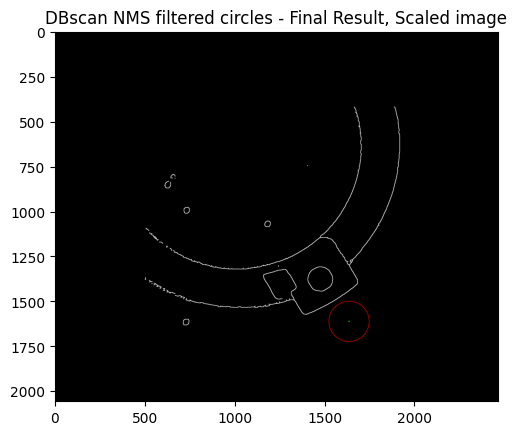

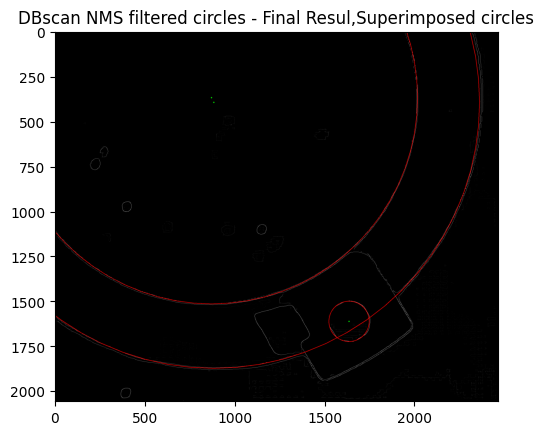

In [7]:
#BIG circle with centre outside the iumage scenario
i = 0
img = test_imgs[i]
scale = 0.6
img_big = scale_image(img, scale)

print('\nFile name: ')
print(files[i].split('/')[-1])
print()

binary, skeleton = preprocess_image(img_big)

circles = calc_scores(detect_circles(skeleton, param2=60, min_radius=500, max_radius=1500), 
                      cv2.distanceTransform(255-binary, cv2.DIST_L2, 3), thr=0.15)
circles = sorted(circles, key=lambda c: c.score, reverse=True)

#constants to recalculate big circle coordinates into old image to superimpose circles
h, w = img.shape[:2]
new_w = int(w * scale)
new_h = int(h * scale)

x_pad = (w - new_w) // 2
y_pad = (h - new_h) // 2

if len(circles) > 0:


    c_NMS_big = Dbscan_NMS(circles, img_big.shape, eps=0.049, min_samples=1)
    plot_circles(c_NMS_big, binary, "DBscan NMS filtered circles - Final Result, Scaled image")
    # plot_circles(circles, binary, "all detected circles")

    c_NMS.extend([Circle(int((c.x-x_pad)/scale), int((c.y-y_pad)/scale), int(c.radius/scale), c.score) for c in c_NMS_big])
    plot_circles(c_NMS, img, "DBscan NMS filtered circles - Final Resul,Superimposed circles")

    print('\nFinal results:')
    for i, circle in enumerate(c_NMS):
            print(f'{i}: x, y, r: ({circle.x}, {circle.y}, {circle.radius}), score: {circle.score:.3f}')
else:
    print('\nNo circles detected')
    plt.imshow(img)
        


File name: 
29.png

[INFO] 'preprocess_image' execution time: 0.2881 s
[INFO] 'detect_circles' execution time: 0.0924 s
[INFO] 'calc_scores' execution time: 0.0369 s
[INFO] 'Dbscan_NMS' execution time: 0.0010 s

Final results:
0: x, y, r: (1471, 865, 141), score: 0.853
1: x, y, r: (1477, 869, 87), score: 0.667
2: x, y, r: (823, 853, 137), score: 0.547
3: x, y, r: (877, 855, 86), score: 0.533
4: x, y, r: (919, 857, 143), score: 0.520
5: x, y, r: (1179, 847, 725), score: 0.440
6: x, y, r: (1179, 853, 688), score: 0.413


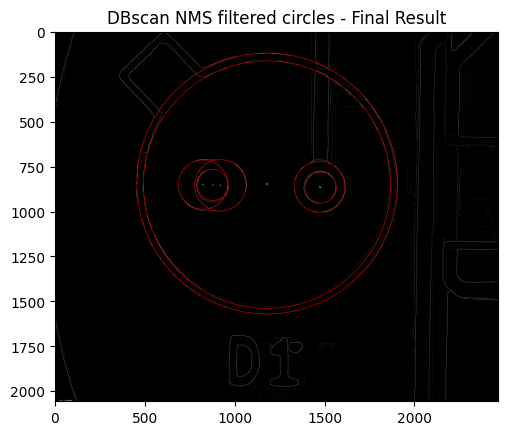

In [8]:
i = 1
img = test_imgs[i]

print('\nFile name: ')
print(files[i].split('/')[-1])
print()

binary, skeleton = preprocess_image(img)

circles = calc_scores(detect_circles(skeleton, param2=150, min_radius=50, max_radius=1000), 
                      cv2.distanceTransform(255-binary, cv2.DIST_L2, 3), thr=0.4)
circles = sorted(circles, key=lambda c: c.score, reverse=True)

if len(circles) > 0:

    c_NMS = Dbscan_NMS(circles, img.shape, eps=0.0049, min_samples=1)
    plot_circles(c_NMS, img, "DBscan NMS filtered circles - Final Result")
    # plot_circles(circles, img, "all detected circles")

    print('\nFinal results:')
    for i, circle in enumerate(c_NMS):
            print(f'{i}: x, y, r: ({circle.x}, {circle.y}, {circle.radius}), score: {circle.score:.3f}')
else:
    print('\nNo circles detected')
    plt.imshow(img)
        


File name: 
13.png

[INFO] 'preprocess_image' execution time: 0.2968 s
[INFO] 'detect_circles' execution time: 1.2339 s
[INFO] 'calc_scores' execution time: 0.3255 s
[INFO] 'Dbscan_NMS' execution time: 0.0010 s

Final results:
0: x, y, r: (887, 115, 68), score: 0.933
1: x, y, r: (2131, 733, 57), score: 0.840
2: x, y, r: (1269, 1579, 51), score: 0.840
3: x, y, r: (1745, 861, 68), score: 0.773
4: x, y, r: (2279, 683, 65), score: 0.707
5: x, y, r: (1003, 925, 84), score: 0.613
6: x, y, r: (1871, 1669, 60), score: 0.587
7: x, y, r: (715, 1297, 59), score: 0.520
8: x, y, r: (1511, 787, 83), score: 0.493
9: x, y, r: (1001, 915, 154), score: 0.467
10: x, y, r: (1251, 683, 87), score: 0.413


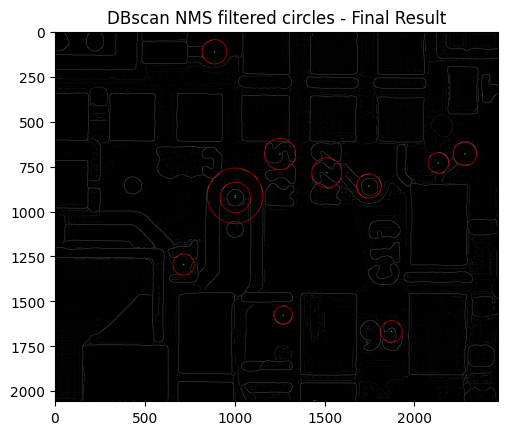

In [9]:
i = 2
img = test_imgs[i]

print('\nFile name: ')
print(files[i].split('/')[-1])
print()

binary, skeleton = preprocess_image(img)

circles = calc_scores(detect_circles(skeleton, param2=150, min_radius=50, max_radius=1000), 
                      cv2.distanceTransform(255-binary, cv2.DIST_L2, 3), thr=0.4)
circles = sorted(circles, key=lambda c: c.score, reverse=True)

if len(circles) > 0:

    c_NMS = Dbscan_NMS(circles, img.shape, eps=0.0049, min_samples=1)
    plot_circles(c_NMS, img, "DBscan NMS filtered circles - Final Result")
    # plot_circles(circles, img, "all detected circles")

    print('\nFinal results:')
    for i, circle in enumerate(c_NMS):
            print(f'{i}: x, y, r: ({circle.x}, {circle.y}, {circle.radius}), score: {circle.score:.3f}')
else:
    print('\nNo circles detected')
    plt.imshow(img)
        


File name: 
1.png

[INFO] 'preprocess_image' execution time: 0.2905 s
[INFO] 'detect_circles' execution time: 0.4339 s
[INFO] 'calc_scores' execution time: 0.1923 s
[INFO] 'Dbscan_NMS' execution time: 0.0012 s

Final results:
0: x, y, r: (831, 1567, 209), score: 0.920
1: x, y, r: (2025, 1533, 151), score: 0.893
2: x, y, r: (833, 1569, 287), score: 0.880
3: x, y, r: (2009, 937, 151), score: 0.867
4: x, y, r: (2009, 947, 287), score: 0.840
5: x, y, r: (1429, 1555, 287), score: 0.800
6: x, y, r: (2007, 945, 211), score: 0.800
7: x, y, r: (1427, 1553, 210), score: 0.787
8: x, y, r: (1427, 1549, 148), score: 0.773
9: x, y, r: (821, 965, 151), score: 0.773
10: x, y, r: (2025, 1541, 288), score: 0.760
11: x, y, r: (831, 1559, 149), score: 0.693
12: x, y, r: (819, 977, 288), score: 0.680
13: x, y, r: (2021, 1539, 209), score: 0.667
14: x, y, r: (361, 541, 325), score: 0.640
15: x, y, r: (1411, 953, 149), score: 0.600
16: x, y, r: (815, 971, 212), score: 0.573
17: x, y, r: (1417, 963, 286), sc

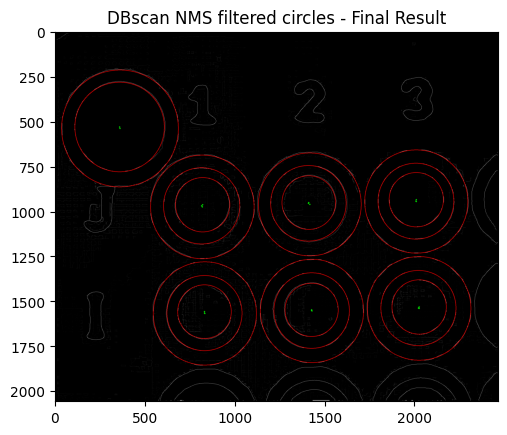

In [10]:
i = 3
img = test_imgs[i]

print('\nFile name: ')
print(files[i].split('/')[-1])
print()

binary, skeleton = preprocess_image(img)

circles = calc_scores(detect_circles(skeleton, param2=150, min_radius=100, max_radius=1000), 
                      cv2.distanceTransform(255-binary, cv2.DIST_L2, 3), thr=0.4)
circles = sorted(circles, key=lambda c: c.score, reverse=True)

if len(circles) > 0:

    c_NMS = Dbscan_NMS(circles, img.shape, eps=0.0049, min_samples=1)
    plot_circles(c_NMS, img, "DBscan NMS filtered circles - Final Result")
    # plot_circles(circles, img, "all detected circles")

    print('\nFinal results:')
    for i, circle in enumerate(c_NMS):
            print(f'{i}: x, y, r: ({circle.x}, {circle.y}, {circle.radius}), score: {circle.score:.3f}')
else:
    print('\nNo circles detected')
    plt.imshow(img)
        

[INFO] 'scale_image' execution time: 0.0087 s

File name: 
8.png

[INFO] 'preprocess_image' execution time: 0.2681 s
[INFO] 'detect_circles' execution time: 0.0656 s
[INFO] 'calc_scores' execution time: 0.1738 s
[INFO] 'Dbscan_NMS' execution time: 0.0019 s

Final results:
0: x, y, r: (1971, 1359, 728), score: 0.107
1: x, y, r: (1835, 1311, 830), score: 0.093
2: x, y, r: (1859, 1319, 703), score: 0.080


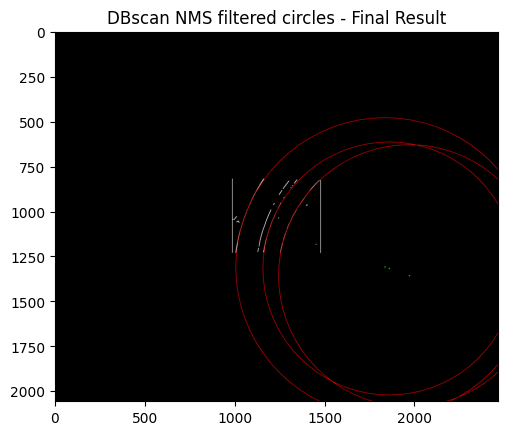

In [11]:
#BIG circle with centre outside the iumage scenario
i = 4
img = test_imgs[i]
img = scale_image(img, 0.2)

print('\nFile name: ')
print(files[i].split('/')[-1])
print()

binary, skeleton = preprocess_image(img)

circles = calc_scores(detect_circles(skeleton, param2=10, min_radius=700, max_radius=850), 
                      cv2.distanceTransform(255-binary, cv2.DIST_L2, 3), thr=0.065)
circles = sorted(circles, key=lambda c: c.score, reverse=True)

if len(circles) > 0:

    c_NMS = Dbscan_NMS(circles, img.shape, eps=0.013, min_samples=1)
    plot_circles(c_NMS, binary, "DBscan NMS filtered circles - Final Result")
    # plot_circles(circles, binary, "all detected circles")

    print('\nFinal results:')
    for i, circle in enumerate(c_NMS):
            print(f'{i}: x, y, r: ({circle.x}, {circle.y}, {circle.radius}), score: {circle.score:.3f}')
else:
    print('\nNo circles detected')
    plt.imshow(img)
        